In [61]:
#encoding:utf-8
#
#created by xiongzihua
#

import os
import sys
import os.path

import random
import numpy as np

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import cv2
import matplotlib.pyplot as plt

class yoloDataset(data.Dataset):
    image_size = 448
    def __init__(self,root,list_file,train=True,transform=None):
        print('data init')
        self.root=root
        self.train = train
        self.transform=transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.mean = (123,117,104)#RGB

        if isinstance(list_file, list):
            # Cat multiple list files together.
            # This is especially useful for voc07/voc12 combination.
            tmp_file = '/tmp/listfile.txt'
            os.system('cat %s > %s' % (' '.join(list_file), tmp_file))
            list_file = tmp_file

        with open(list_file) as f:
            lines  = f.readlines()

        for line in lines:
            splited = line.strip().split()
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box=[]
            label=[]
            for i in range(num_boxes):
                x = float(splited[1+5*i])
                y = float(splited[2+5*i])
                x2 = float(splited[3+5*i])
                y2 = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x,y,x2,y2])
                label.append(int(c)+1)
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        print(fname)
        img = cv2.imread(os.path.join(self.root,fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes)
        img = self.BGR2RGB(img) #because pytorch pretrained model use RGB

        img = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels)# 7x7x30

        return img,target
    def __len__(self):
        return self.num_samples

    def encoder(self,boxes,labels):
        '''
        boxes (tensor) [[x1,y1,x2,y2],[]]
        labels (tensor) [...]
        return 7x7x30
        '''
        grid_num = 14
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy = ij*cell_size #匹配到的网格的左上角相对坐标
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
        return target
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    





In [62]:
import os
root = r"E:\Deep Learning Projects\datasets\VOCdevkit\VOC2012\JPEGImages"
l1 = os.listdir(r"E:\\Deep Learning Projects\\datasets\\VOCdevkit\\VOC2012\\JPEGImages\\")
l2 = os.listdir(r"E:\Deep Learning Projects\datasets\VOCdevkit\VOC2012\Annotations")
ds = yoloDataset(root,  "2012.txt", train=False)

data init


2007_008218.jpg


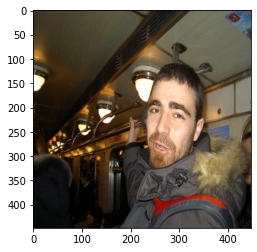

In [70]:
import matplotlib.pyplot as plt

plt.imshow(ds[0][0])

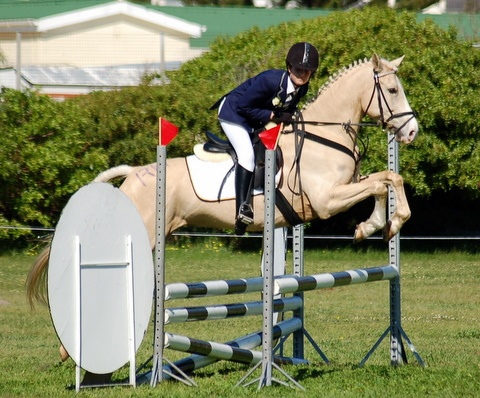

In [30]:
ds[100]